### Link predication with Word2vec method

So this is the implemenetation that I am thinking about: I will creat train, test and validation set of edges. Then in the train edges we will train the network. First we will creat positive and negative graph from the train edges. The positive graph is the one with the real edges and real weights and the negative or corrupted graph is one with real edges and 1-correct_weights as corrupt weights. Now For each node (for example node A), we generate a positive sample edge with the probability of its edge and we will try to make the two nodes at the both ends of that edge close to each other (for example node A and node B). Then for that specific node(A), we will generate 5 more examples from the corrupted graph (this time, edges that have "real small weight values" and therefore "high big corrupt weight values" will be chosen) then we will try to make that node "A" far from its negative examples. 

In [3]:
import os
import torch
import time
import numpy as np
import scipy.sparse as sp
import torch.nn as nn
import networkx as nx
from stellargraph import StellarDiGraph
import cell.BiasedDirectedWeightedWalk as BDWW
from cell import utils, plot_utils, analysis, graph_utils
from cell.Word2vec import prepare_vocab, dataloader, wv

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import imp
from cell import  utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(plot_utils)
imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

Get the edge list and creat a train, validation and test set from all the edges:

In [118]:
roi = "VISp"
project_name = "NPP_GNN_project"
layer = "base_unnormalized_allcombined"

edge_dir = utils.get_edgelist_dir(roi,
                                  project_name,
                                  layer) 
edge_filename = "selfconnection_added_edges_node21_32_removed.csv"
edge_list = pd.read_csv(os.path.join(edge_dir, edge_filename), index_col="Unnamed: 0").reset_index(drop=True)
edge_list[['source', 'target']] = edge_list[['source', 'target']].astype(str)

In [119]:
edge_list

,source,target,weight
0,0,2,0.959233
1,0,9,1.165541
2,0,11,0.896152
3,0,13,0.577894
4,0,36,0.278507
...,...,...,...
8276,29,73,0.014583
8277,15,15,0.142562
8278,15,16,0.051693
8279,15,17,0.104671


In [145]:
eids = np.random.permutation(edge_list.shape[0]).tolist()
train_eids = eids[:int(len(eids) * 0.8)]
valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
test_eids = eids[int(len(eids) * 0.9):]

train_edges = edge_list.iloc[train_eids]
valid_edges = edge_list.iloc[valid_eids]
test_edges = edge_list.iloc[test_eids]

train_edges[['source', 'target']] = train_edges[['source', 'target']].astype(str)
nxg = graph_utils.build_nx_graph(source_target_weight=train_edges, directed=True)
train_g = StellarDiGraph(nxg)

/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [160]:
# import h5py
# filename = "/Users/fahimehb/Downloads/CTX_Hip_SS_counts.h5"

# with h5py.File(filename, "r") as f:
#     # List all groups
#     print("Keys: %s" % f.keys())
#     a_group_key = list(f.keys())[0]

#     # Get the data
#     data = list(f[a_group_key])

Lets normalize the outgoing edges for each node

In [55]:
edge_list = edge_list.assign(
    normal_weight=
    edge_list.weight/edge_list.groupby('source').weight.transform('sum'))

edge_list

,source,target,weight,normal_weight
0,0,2,0.959233,0.018627
1,0,9,1.165541,0.022634
2,0,11,0.896152,0.017402
3,0,13,0.577894,0.011222
4,0,36,0.278507,0.005408
...,...,...,...,...
8276,29,73,0.014583,0.003733
8277,15,15,0.142562,0.005743
8278,15,16,0.051693,0.002082
8279,15,17,0.104671,0.004217


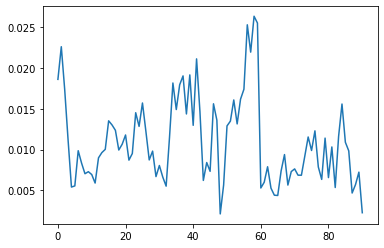

In [57]:
plt.plot(edge_list[edge_list['source']=="0"]['normal_weight'].tolist())

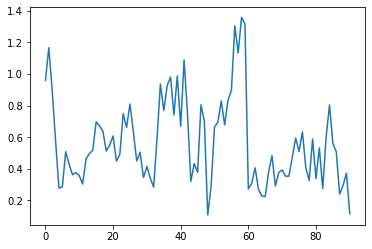

In [58]:
plt.plot(edge_list[edge_list['source']=="0"]['weight'].tolist())

This way all the weights are small and close to each other and taking negative samples from this set is not a good idea. What if we threshold the edgelist and then again normalize it? let say anyvalue less than 0.5 is going to be set to zero.

In [102]:
roi = "VISp"
project_name = "NPP_GNN_project"
layer = "base_unnormalized_allcombined"

edge_dir = utils.get_edgelist_dir(roi,
                                  project_name,
                                  layer) 
edge_filename = "selfconnection_added_edges_node21_32_removed.csv"
edge_list = pd.read_csv(os.path.join(edge_dir, edge_filename), index_col="Unnamed: 0").reset_index(drop=True)
edge_list[['source', 'target']] = edge_list[['source', 'target']].astype(str)

In [97]:
# edge_list = edge_list[edge_list['weight']>0.8] 

In [106]:
edge_list = edge_list.assign(
    normal_weight=
    edge_list.weight/edge_list.groupby('source').weight.transform('sum'))

edge_list

,source,target,weight,normal_weight
0,0,2,0.959233,0.018627
1,0,9,1.165541,0.022634
2,0,11,0.896152,0.017402
3,0,13,0.577894,0.011222
4,0,36,0.278507,0.005408
...,...,...,...,...
8276,29,73,0.014583,0.003733
8277,15,15,0.142562,0.005743
8278,15,16,0.051693,0.002082
8279,15,17,0.104671,0.004217


In [104]:
edge_list[edge_list['source']=="0"]

,source,target,weight
0,0,2,0.959233
1,0,9,1.165541
2,0,11,0.896152
3,0,13,0.577894
4,0,36,0.278507
...,...,...,...
8036,0,82,0.507233
8041,0,34,0.240895
8042,0,35,0.294299
8043,0,39,0.372847


In [100]:
[i for i in edge_list[edge_list['source']=="0"]['normal_weight'].tolist() if i > 0 ] 

[0.053215042946028156,
 0.06466034572667716,
 0.04971550381999599,
 0.04492593919540373,
 0.051936551870634125,
 0.05131166025128231,
 0.054422355854638164,
 0.05477513892202121,
 0.06039891657713058,
 0.044649260760626974,
 0.045995860365776416,
 0.04626595539066316,
 0.049746845291654296,
 0.07234512108801026,
 0.06276016417146203,
 0.07534400937691603,
 0.07296388183187347,
 0.0445674465592061]

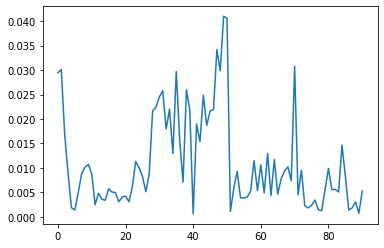

In [112]:
plt.plot(edge_list[edge_list['source']=="1"]['normal_weight'].tolist())

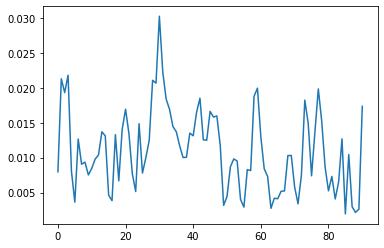

In [117]:
plt.plot(edge_list[edge_list['source']=="90"]['normal_weight'].tolist())

/Users/fahimehb/anaconda3/envs/py374/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Now built a graph on the train edges only:

In [122]:
sdg.out_nodes('0')

['39',
 '89',
 '40',
 '53',
 '90',
 '15',
 '52',
 '74',
 '54',
 '20',
 '5',
 '41',
 '57',
 '69',
 '13',
 '29',
 '82',
 '26',
 '23',
 '36',
 '24',
 '46',
 '34',
 '27',
 '87',
 '30',
 '81',
 '86',
 '72',
 '42',
 '79',
 '51',
 '65',
 '11',
 '56',
 '3',
 '64',
 '14',
 '37',
 '22',
 '38',
 '88',
 '63',
 '83',
 '75',
 '12',
 '60',
 '78',
 '31',
 '77',
 '91',
 '47',
 '18',
 '45',
 '8',
 '17',
 '62',
 '6',
 '50',
 '0',
 '66',
 '44',
 '49',
 '25',
 '70',
 '43',
 '35',
 '73']

Now walk on the train graph

In [7]:
weighted = True
directed = True
length = 1000
n = 1
p = 1
q = 1

BDWW.BeginWalk(sdg, begin_checks=True, weighted=weighted, directed=directed)

rw = BDWW.BiasedDirectedRandomWalk(sdg,
                                   directed=directed,
                                   weighted=weighted,
                                   begin_checks=False)

nodes = list(sdg.nodes())
walks = rw.run(nodes=nodes,
               length=length,
               n=n,
               p=p,
               q=q,
               weighted=weighted,
               directed=directed)


Checking all the weights on all the edges!
Computing the node importance!


In [8]:
corpus = walks
vocabulary = prepare_vocab.get_vocabulary(corpus)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=False)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=False)

new_tuples = prepare_vocab.get_word_context_tuples(corpus=corpus, window=2)

dataset = dataloader.WalkDataset(new_tuples, word_2_index)

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          batch_size=2000, 
                                          shuffle=False,
                                          num_workers=1)

examples = iter(data_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

lenght of vocabulary: 91
There are 363454 pairs of target and context words
torch.Size([2000]) torch.Size([2000])


In [9]:
vocab_size = len(vocabulary)  
embedding_size = 2
learning_rate = 0.001
n_epochs = 500

In [10]:
criterion = nn.CrossEntropyLoss()

model = wv.Word2Vec(embedding_size=embedding_size, vocab_size=vocab_size)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
n_total_steps = len(data_loader)

training_loss = []

for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        prediction = model(context)
        loss = criterion(prediction, target)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    t1 = time.time()
    print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

time is 5.08
epoch: 1/500, loss:4.6747
time is 5.87
epoch: 2/500, loss:4.5676
time is 5.03
epoch: 3/500, loss:4.5123
time is 5.00
epoch: 4/500, loss:4.4821
time is 4.98
epoch: 5/500, loss:4.4652
time is 5.00
epoch: 6/500, loss:4.4558
time is 4.99
epoch: 7/500, loss:4.4505
time is 5.06
epoch: 8/500, loss:4.4474
time is 5.30
epoch: 9/500, loss:4.4456
time is 4.95
epoch: 10/500, loss:4.4445
time is 4.98
epoch: 11/500, loss:4.4437
time is 5.02
epoch: 12/500, loss:4.4431
time is 4.91
epoch: 13/500, loss:4.4425
time is 4.90
epoch: 14/500, loss:4.4421
time is 4.96
epoch: 15/500, loss:4.4416
time is 5.02
epoch: 16/500, loss:4.4411
time is 4.97
epoch: 17/500, loss:4.4406
time is 5.12
epoch: 18/500, loss:4.4401
time is 4.92
epoch: 19/500, loss:4.4396
time is 4.99
epoch: 20/500, loss:4.4391
time is 5.19
epoch: 21/500, loss:4.4387
time is 5.02
epoch: 22/500, loss:4.4383
time is 4.96
epoch: 23/500, loss:4.4379
time is 5.08
epoch: 24/500, loss:4.4376
time is 4.95
epoch: 25/500, loss:4.4374
time is 5

In [15]:
# sm = nn.LogSoftmax(dim=1)
# nnl = nn.CrossEntropyLoss()
# print(sm(prediction[9:10])[0][target[9:10].numpy()[0]])
# print(nnl(prediction[9:10], target[9:10]))

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


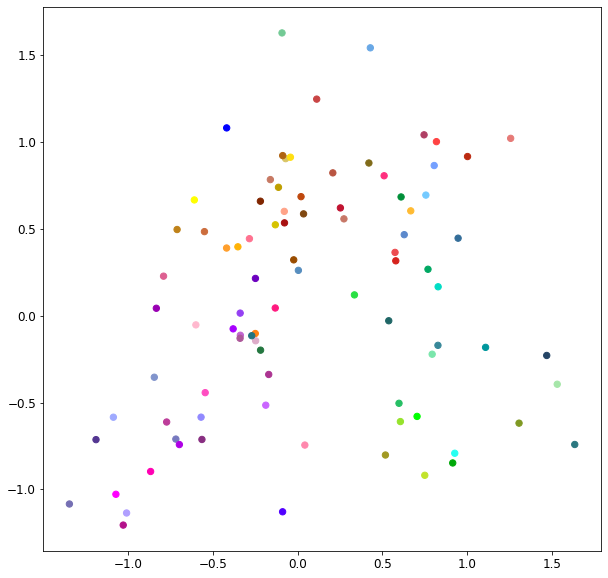

In [16]:
cldf = utils.read_visp_npp_cldf()
vectors = model.embeddings.weight.detach().numpy()
vectors = vectors[1:]
idx = [i for i in index_2_word.values()][1:]
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = idx,
                                                 ndim=2, 
                                                 cl_df=cldf,
                                                 padding_label = "0")

fig = plot_utils.plot_embedding(data=data, 
                                cl_df=cldf,
                                plot_dim=2, 
                                plot_size=(10,10), 
                                annotation=False)

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


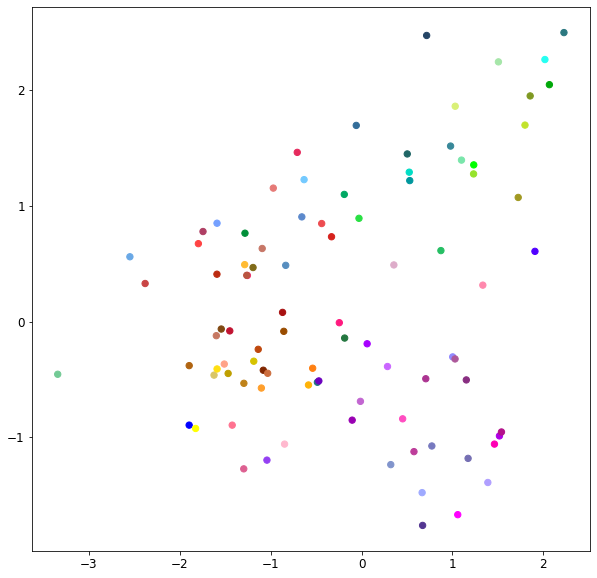

In [110]:
cldf = utils.read_visp_npp_cldf()
vectors = pd.read_csv("/Users/fahimehb/Downloads/model_size_2_iter_1000_window_2_lr_0.001_bs_2000_node21_32_removed.csv")
vectors = vectors.set_index("cluster_id")
vectors = vectors.merge(cldf, on='cluster_id')


fig = plot_utils.plot_embedding(data=vectors, 
                          cl_df=cldf,
                          plot_dim=2, 
                          plot_size=(10,10), 
                          annotation=False)

In [36]:
corpus[0]

['0',
 '71',
 '34',
 '10',
 '5',
 '35',
 '17',
 '59',
 '27',
 '14',
 '56',
 '79',
 '51',
 '27',
 '8',
 '10',
 '1',
 '29',
 '29',
 '20',
 '50',
 '77',
 '22',
 '53',
 '37',
 '56',
 '91',
 '5',
 '78',
 '11',
 '92',
 '86',
 '36',
 '92',
 '11',
 '84',
 '70',
 '78',
 '70',
 '71',
 '46',
 '5',
 '87',
 '67',
 '7',
 '7',
 '22',
 '27',
 '9',
 '28',
 '15',
 '88',
 '71',
 '28',
 '15',
 '67',
 '27',
 '49',
 '47',
 '67',
 '5',
 '22',
 '5',
 '26',
 '56',
 '57',
 '56',
 '64',
 '22',
 '54',
 '68',
 '73',
 '70',
 '28',
 '1',
 '88',
 '2',
 '51',
 '26',
 '23',
 '78',
 '47',
 '62',
 '42',
 '84',
 '9',
 '78',
 '49',
 '59',
 '13',
 '76',
 '43',
 '27',
 '59',
 '81',
 '79',
 '47',
 '79',
 '27',
 '43',
 '58',
 '12',
 '67',
 '50',
 '38',
 '34',
 '75',
 '0',
 '18',
 '68',
 '78',
 '25',
 '18',
 '29',
 '7',
 '30',
 '13',
 '30',
 '29',
 '10',
 '28',
 '3',
 '77',
 '49',
 '86',
 '13',
 '27',
 '4',
 '29',
 '3',
 '87',
 '92',
 '50',
 '80',
 '11',
 '7',
 '31',
 '27',
 '40',
 '53',
 '79',
 '80',
 '12',
 '69',
 '37',
 '50'

In [21]:
import numpy as np
from dgl.graph import DGLGraph
import torch
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import random
from dgl import DGLGraph
import seaborn as sns
from cell import plot_utils, utils
from dgl.nn.pytorch import conv as dgl_conv
from dgl.data.utils import download, extract_archive, get_download_dir, _get_dgl_url
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class NPPDataset(object):
    def __init__(self, path, self_loop=False):
        self_loop_str = ""
        if self_loop:
            self_loop_str = "_self_loop"
        
        with open(path, 'rb') as handle:
            npp_data = pickle.load(handle)
        # graph
        adj = npp_data['npp']
        self.graph = DGLGraph(adj, readonly=True)
        self.features = npp_data["feature"]
        self.labels = npp_data["label"]
        self.num_labels = 93

        print('Finished data loading.')
        print('  NumNodes: {}'.format(self.graph.number_of_nodes()))
        print('  NumEdges: {}'.format(self.graph.number_of_edges()))
        print('  NumFeats: {}'.format(self.features.shape[1]))
        print('  NumClasses: {}'.format(self.num_labels))

    def __getitem__(self, idx):
        assert idx == 0, "NPP Dataset only has one graph"
        g = self.graph
        g.ndata['feat'] = self.features
        g.ndata['label'] = self.labels
        return g
    
    def __len__(self):
        return 1

In [13]:
class Word2Vec(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, context_word):
        out = self.embeddings(context_word)
        out = self.linear(out)
        return out


In [14]:
cldf = utils.read_visp_npp_cldf()

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


In [ ]:
# NCE loss
def NCE_loss(pos_score, neg_score, neg_sample_size):
    pos_score = F.logsigmoid(pos_score)
    neg_score = F.logsigmoid(-neg_score).reshape(-1, neg_sample_size)
    return -pos_score - torch.sum(neg_score, dim=1)


class LinkPrediction(nn.Module):
    def __init__(self, gconv_model):
        super(LinkPrediction, self).__init__()
        self.gconv_model = gconv_model

    def forward(self, g, context_word, neg_sample_size):
        emb = self.Word2Vec(context_word)
        pos_g, neg_g = edge_sampler(g, neg_sample_size, return_false_neg=False)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb)
        return torch.mean(NCE_loss(pos_score, neg_score, neg_sample_size))

In [ ]:
def edge_sampler(g, neg_sample_size, edges=None, return_false_neg=True):
    sampler = dgl.contrib.sampling.EdgeSampler(g, batch_size=int(g.number_of_edges()/10),
                                               seed_edges=edges,
                                               neg_sample_size=neg_sample_size,
                                               negative_mode='tail',
                                               shuffle=True,
                                               return_false_neg=return_false_neg)
    sampler = iter(sampler)
    return next(sampler)

In [ ]:
def score_func(g, emb, parent_graph=False):
    src_nid, dst_nid = g.all_edges(order='eid')
    # Get the node Ids in the parent graph.
    if not parent_graph:
        src_nid = g.parent_nid[src_nid]
        dst_nid = g.parent_nid[dst_nid]
    # Read the node embeddings of the source nodes and destination nodes.
    pos_heads = emb[src_nid]
    pos_tails = emb[dst_nid]
    return torch.sum(pos_heads * pos_tails, dim=1)

In [ ]:
def LPEvaluate(gconv_model, g, features, eval_eids, neg_sample_size):
    gconv_model.eval()
    with torch.no_grad():
        emb = gconv_model(g, features)
        
        pos_g, neg_g = edge_sampler(g, neg_sample_size, eval_eids, return_false_neg=True)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb).reshape(-1, neg_sample_size)
        filter_bias = neg_g.edata['false_neg'].reshape(-1, neg_sample_size)

        pos_score = F.logsigmoid(pos_score)
        neg_score = F.logsigmoid(neg_score)
        neg_score -= filter_bias.float()
        pos_score = pos_score.unsqueeze(1)
        rankings = torch.sum(neg_score >= (pos_score), dim=1) + 1
        return np.mean(1.0/rankings.cpu().numpy())

In [ ]:
criterion = nn.CrossEntropyLoss()

model = wv.Word2Vec(embedding_size=embedding_size, vocab_size=vocab_size)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
n_total_steps = len(data_loader)

training_loss = []

for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        prediction = model(context)
        loss = criterion(prediction, target)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    t1 = time.time()
    print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')





    train_eids, valid_eids, test_eids, train_g = prepare_train_test_valid(g)

    # initialize graph
    dur = []
    for epoch in range(n_epochs):
        model.train()
        loss = model(train_g, features, neg_sample_size)
        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
        acc = LPEvaluate(gconv_model, g, features, valid_eids, neg_sample_size)
        #print("Epoch {:05d} | Loss {:.4f} | MRR {:.4f}".format(epoch, loss.item(), acc))

    print()
    # Let's save the trained node embeddings.
    acc = LPEvaluate(gconv_model, g, features, test_eids, neg_sample_size)
    print("Test MRR {:.4f}".format(acc))
    return gconv_model